In [8]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio
from collections import deque
from IPython.display import Video
from numba import jit
from random import random, randint, sample

from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.wrappers.grouped import GroupedActionsObservations
from tetris_gymnasium.mappings.rewards import RewardsMapping

In [9]:
def make_custom_tetris_env(
    alife=1,
    clear_line=1,
    game_over=0,
    invalid_action=-1,
    render_mode=None
):

    # Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        render_mode=render_mode  # Uncomment if needed
    )
    
    env = GroupedActionsObservations(env)
    
    return env

In [10]:
@jit(nopython=True)
def calculate_features_numba(inner_boards, lines_cleared_norm):
    """
    JIT-compiled feature calculation
    """
    num_actions, rows, cols = inner_boards.shape
    features = np.zeros((num_actions, 4), dtype=np.float32)
    
    for i in range(num_actions):
        board = inner_boards[i]
        
        # Heights
        heights = np.zeros(cols, dtype=np.int32)
        for col in range(cols):
            for row in range(rows):
                if board[row, col] != 0:
                    heights[col] = rows - row
                    break
        
        agg_height = np.sum(heights)
        
        # Holes
        holes = 0
        for col in range(cols):
            found_surface = False
            for row in range(rows):
                if board[row, col] != 0:
                    found_surface = True
                elif found_surface:
                    holes += 1
        
        # Bumpiness
        bumpiness = 0
        for col in range(cols - 1):
            bumpiness += abs(heights[col] - heights[col + 1])
        
        features[i] = [
            agg_height,
            lines_cleared_norm,
            holes,
            bumpiness
        ]
    
    return features

def extract_features_from_observations(board_state, info):
    """
    Numba-accelerated version
    """
    # Batch extract inner boards
    inner_boards = board_state[:, :-4, 4:-4]
    
    if isinstance(inner_boards, torch.Tensor):
        inner_boards = inner_boards.cpu().numpy()
    
    inner_boards = np.where(inner_boards == 1, 0, inner_boards)
    
    # JIT-compiled feature calculation
    features = calculate_features_numba(inner_boards, info["lines_cleared"] / 4.0)
    
    return torch.from_numpy(features)

@jit(nopython=True)
def calculate_features_numba_single(inner_boards, lines_cleared_norm):
    """
    JIT-compiled feature calculation
    """
    rows, cols = inner_boards.shape
    
    features = []
    
    board = inner_boards
        
    # Heights
    heights = np.zeros(cols, dtype=np.int32)
    for col in range(cols):
        for row in range(rows):
            if board[row, col] != 0:
                heights[col] = rows - row
                break
    
    agg_height = np.sum(heights)
    
    # Holes
    holes = 0
    for col in range(cols):
        found_surface = False
        for row in range(rows):
            if board[row, col] != 0:
                found_surface = True
            elif found_surface:
                holes += 1
    
    # Bumpiness
    bumpiness = 0
    for col in range(cols - 1):
        bumpiness += abs(heights[col] - heights[col + 1])
        
    features.append([agg_height, lines_cleared_norm, holes, bumpiness])
    
    return features

def extract_features_from_observations_single(board_state, info):
    """
    Numba-accelerated version
    """
    # Batch extract inner boards
    inner_boards = board_state[:-4, 4:-4]

    
    if isinstance(inner_boards, torch.Tensor):
        inner_boards = inner_boards.cpu().numpy()
    
    inner_boards = np.where(inner_boards == 1, 0, inner_boards)
    
    # JIT-compiled feature calculation
    features = calculate_features_numba_single(inner_boards, info["lines_cleared"] / 4.0)
    
    return torch.from_numpy(np.array(features, dtype=np.float32))

In [11]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.fc1 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(inplace=True))
        self.fc2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.fc3 = nn.Sequential(nn.Linear(64, 1))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [12]:
class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    # Here we define function that will add our priority score in the sumtree leaf and add the experience in data:
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0
            
    # Update the leaf priority score and propagate the change through tree
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = np.asarray(priority).item()

        # then propagate the change through tree
        # this method is faster than the recursive loop in the reference code
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += np.asarray(change).item()
        
    # Here build a function to get a leaf from our tree. So we'll build a function to get the leaf_index, priority value of that leaf and experience associated with that leaf index:
    def get_leaf(self, v):
        parent_index = 0

        # the while loop is faster than the method in the reference code
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

# Now we finished constructing our SumTree object, next we'll build a memory object.
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 10.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        self.tree = SumTree(capacity)
        
    # Next, we define a function to store a new experience in our tree.
    # Each new experience will have a score of max_prority (it will be then improved when we use this exp to train our DDQN).
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
        
    # Now we create sample function, which will be used to pick batch from our tree memory, which will be used to train our model.
    # - First, we sample a minibatch of n size, the range [0, priority_total] into priority ranges.
    # - Then a value is uniformly sampled from each range.
    # - Then we search in the sumtree, for the experience where priority score correspond to sample values are retrieved from.
    def sample(self, n):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i]= index
            if type(data) == int:
                print(value)
                print(index)
                print(data)
                print("Total priority is {}, this should be smaller than batch size.".format(self.tree.total_priority()))
                print(len(self.tree.data))
                print(len(self.tree.tree))
                raise ValueError('What just happened?')
            minibatch.append([data[0],data[1],data[2],data[3],data[4]])

        return b_idx, minibatch
    
    # Update the priorities on the tree
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [ ]:
def train(episodes=3000, batch_size=512, gamma=0.99, lr=1e-4,
                   epsilon_initial=1.0, epsilon_min=0.05, epsilon_decay=0.9985, epsilon=1,
                   target_update_freq=10, replay_memory_size=30000, num_decay_epochs=2000):
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    env = make_custom_tetris_env()
    DQN_Model_Policy = DQN().to(device)
    DQN_Model_Target = DQN().to(device)
    optimizer = torch.optim.Adam(DQN_Model_Policy.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    rewards_history = []
    lines_history = []
    loss_history = []
    step_history = []
    td_error_history =[]


    replay_memory = Memory(capacity=replay_memory_size)
    num_experiences = 0
    
    warmup_fraction = 0.1
    warmup_buffer_size = int(replay_memory_size * warmup_fraction)
    print(f"Starting warmup phase to fill {warmup_buffer_size} experiences...")
    warmup_episodes = 0
    
    while num_experiences < warmup_buffer_size:
        state, info = env.reset()
        done = False
        
        features_before = torch.zeros(4, device='cuda:0')
        
        lines_cleared = 0
        
        warmup_episodes += 1
        if warmup_episodes % 50 == 0:
            print("Number of warmup episodes", warmup_episodes)
        
        while not done:
            # Extract normalized features for all possible placements
            # state shape: (40, 20, 10) -> features shape: (40, 4)
            features = extract_features_from_observations(state, info).to(device)
            
            DQN_Model_Policy.eval()
            with torch.no_grad():
                prediction = DQN_Model_Policy(features)[:, 0]  # Shape: (40,)
            DQN_Model_Policy.train()
            
            legal_actions = info.get('action_mask', None)
            if legal_actions is not None:
                if hasattr(legal_actions, 'numpy'):
                    legal_actions = legal_actions.numpy()
                legal_indices = np.where(legal_actions)[0]
                
                if np.random.rand() < epsilon:
                    # Explore: random legal action
                    action = np.random.choice(legal_indices)
                else:
                    # Exploit: best legal action
                    legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
                    masked_q_values = prediction.clone()
                    masked_q_values[~legal_tensor] = -float('inf')
                    action = masked_q_values.argmax().item()
            else:
                # No legal action masking
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = prediction.argmax().item()
        
            features_recommended = features[action, :]
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            if info["lines_cleared"] == 1:
                reward *= 10            
            if info["lines_cleared"] == 2:
                reward *= 2
            elif info["lines_cleared"] == 3:
                reward *= 3
            elif info["lines_cleared"] == 4:
                reward *= 4
                        
            experience = features_before, action, reward, features_recommended, done
            replay_memory.store(experience)
            features_before = features_recommended
            state = next_state
            num_experiences += 1
            
    for ep in range(episodes):
        state, info = env.reset()
        done = False
        
        features_before = torch.zeros(4, device='cuda:0')
        
        lines_cleared = 0
        line_reward = 0
        time_step = 0
        
        epsilon = epsilon_min + (max(num_decay_epochs - ep, 0) * (epsilon_initial - epsilon_min) / num_decay_epochs)
        while not done:
            time_step += 1
            # Extract normalized features for all possible placements
            # state shape: (40, 20, 10) -> features shape: (40, 4)
            features = extract_features_from_observations(state, info).to(device)
            
            DQN_Model_Policy.eval()
            with torch.no_grad():
                prediction = DQN_Model_Policy(features)[:, 0]  # Shape: (40,)
            DQN_Model_Policy.train()
            
            legal_actions = info.get('action_mask', None)
            if legal_actions is not None:
                if hasattr(legal_actions, 'numpy'):
                    legal_actions = legal_actions.numpy()
                legal_indices = np.where(legal_actions)[0]
                
                if np.random.rand() < epsilon:
                    # Explore: random legal action
                    action = np.random.choice(legal_indices)
                else:
                    # Exploit: best legal action
                    legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
                    masked_q_values = prediction.clone()
                    masked_q_values[~legal_tensor] = -float('inf')
                    action = masked_q_values.argmax().item()
            else:
                # No legal action masking
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = prediction.argmax().item()
        
            features_recommended = features[action, :]
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            if info["lines_cleared"] == 1:
                reward *= 1            
            elif info["lines_cleared"] == 2:
                reward *= 2
            elif info["lines_cleared"] == 3:
                reward *= 3
            elif info["lines_cleared"] == 4:
                reward *= 4
                        
            experience = features_before, action, reward, features_recommended, done
            replay_memory.store(experience)
            
            features_before = features_recommended
            state = next_state
            
            lines_cleared += info["lines_cleared"]
            if info["lines_cleared"] > 0:
                line_reward += reward
        
            tree_idx, batch = replay_memory.sample(batch_size)
            state_batch, _, reward_batch, next_state_batch, done_batch = zip(*batch)
            state_batch = torch.stack(tuple(state for state in state_batch))
            reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None])
            next_state_batch = torch.stack(tuple(state for state in next_state_batch))
            
            if torch.cuda.is_available():
                state_batch = state_batch.cuda()
                reward_batch = reward_batch.cuda()
                next_state_batch = next_state_batch.cuda()

            q_values = DQN_Model_Policy(state_batch)
            DQN_Model_Target.eval()
            with torch.no_grad():
                next_prediction_batch = DQN_Model_Target(next_state_batch)
            DQN_Model_Target.train()

            y_batch = torch.cat(
            tuple(reward if done else reward + gamma * prediction for reward, done, prediction in
                    zip(reward_batch, done_batch, next_prediction_batch)))[:, None]
            
            optimizer.zero_grad()
            loss = criterion(q_values, y_batch)
            loss.backward()
            optimizer.step()
            
            DQN_Model_Policy.eval()
            DQN_Model_Target.eval()
            with torch.no_grad():
                td_errors = np.abs(q_values.detach().cpu().numpy() - y_batch.cpu().numpy())
                replay_memory.batch_update(tree_idx, td_errors)
                
            DQN_Model_Target.train()
            DQN_Model_Policy.eval()
            
        if ep % target_update_freq == 0:
            with torch.no_grad():
                DQN_Model_Target.load_state_dict(DQN_Model_Policy.state_dict())

        step_history.append(time_step)
        loss_history.append(loss.item())    
        rewards_history.append(line_reward)
        lines_history.append(lines_cleared)
        td_error_history.append(np.mean(td_errors))
        
        print(f"Episode {ep}, Total Reward: {line_reward:.2f}, Lines Cleared: {lines_cleared}, Epsilon: {epsilon:.3f}, Step: {time_step}")
            
    return DQN_Model_Policy, rewards_history, lines_history, loss_history, step_history, td_error_history

In [14]:
q_net, history, lines, loss, step_count, td_error = train(episodes=3000)

Using device: cuda
Starting warmup phase to fill 3000 experiences...
Number of warmup episodes 50
Number of warmup episodes 100
Number of warmup episodes 150
Episode 0, Total Reward: 0.00, Lines Cleared: 0, Epsilon: 1.000, Step: 0


KeyboardInterrupt: 

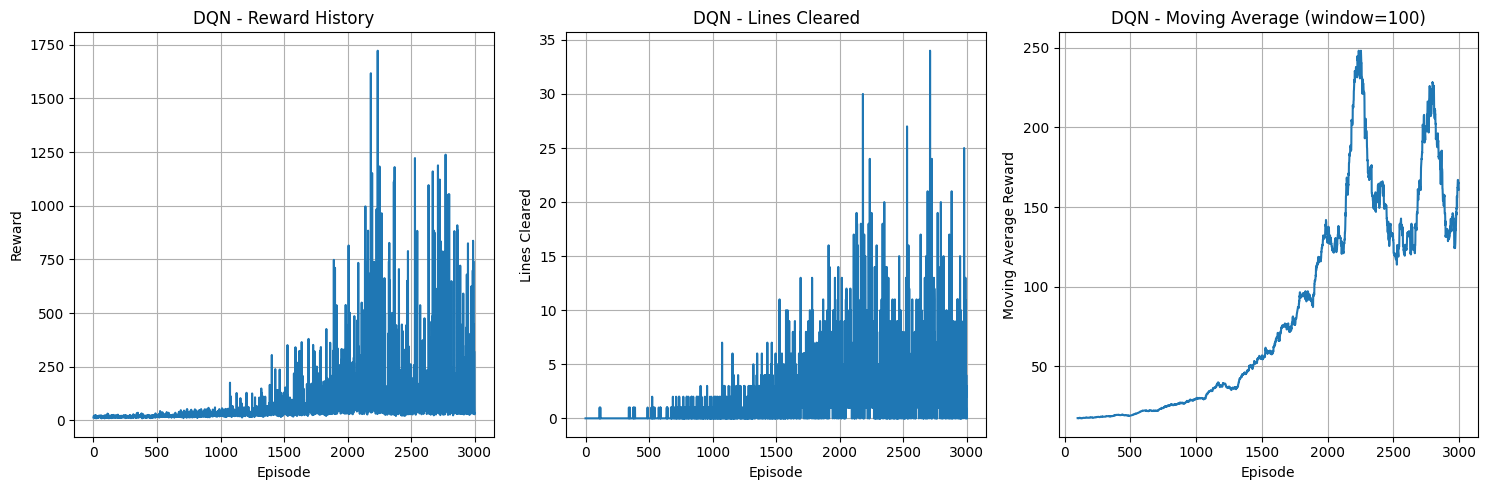


📊 Final Training Statistics:
Total Episodes: 3000
Average Reward (last 100): 160.91
Best Reward: 1722.00
Total Lines Cleared: 5969
Average Lines/Episode: 1.99
Max Lines in Single Episode: 34


In [ ]:
plt.figure(figsize=(18, 10))

# Reward History
plt.subplot(2, 3, 1)
plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN - Reward History")
plt.grid(True)

# Lines Cleared History
plt.subplot(2, 3, 2)
plt.plot(lines)
plt.xlabel("Episode")
plt.ylabel("Lines Cleared")
plt.title("DQN - Lines Cleared")
plt.grid(True)

# Moving Average Reward
plt.subplot(2, 3, 3)
window = 100
if len(history) >= window:
    moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(history)), moving_avg)
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.title(f"DQN - Moving Average (window={window})")
plt.grid(True)

# Loss History
plt.subplot(2, 3, 4)
plt.plot(loss)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("DQN - Loss History")
plt.grid(True)

# Steps History
plt.subplot(2, 3, 5)
plt.plot(step_count)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("DQN - Steps History")
plt.grid(True)

# TD Error History
plt.subplot(2, 3, 6)
plt.plot(td_error)
plt.xlabel("Episode")
plt.ylabel("TD Error")
plt.title("DQN - TD Error History")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Training Statistics:")
print(f"Total Episodes: {len(history)}")
print(f"Average Steps per Episode: {np.mean(step_count):.2f}")
print(f"Average Reward per Episode: {np.mean(history):.2f}")
print(f"Best Reward: {np.max(history):.2f}")
print(f"Total Lines Cleared: {sum(lines)}")
print(f"Max Lines in Single Episode: {np.max(lines)}")
print(f"Average Lines per Episode: {np.mean(lines):.2f}")


In [ ]:
# Evaluate trained DQN and save gameplay video
device = next(q_net.parameters()).device
env = make_custom_tetris_env(render_mode="rgb_array")
video_path = "tetris_FINAL_PER.mp4"
writer = imageio.get_writer(video_path, fps=30)
episodes = 1

print(f"\n🎮 Evaluating trained agent for {episodes} episodes on {device}...\n")

for ep in range(episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    lines_cleared = 0

    while not done:
        # Extract features for all possible placements
        # state shape: (N, H, W) -> features shape: (N, 4)
        features = extract_features_from_observations(state, info).to(device)

        # Compute Q-values for all placements
        with torch.no_grad():
            q_values = q_net(features)  # Shape: (N,)

        # Legal action masking
        legal_actions = info.get("action_mask", None)
        if legal_actions is not None:
            if hasattr(legal_actions, "numpy"):
                legal_actions = legal_actions.numpy()
            legal_indices = np.where(legal_actions)[0]
            legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
            masked_q_values = q_values.clone()
            masked_q_values[~legal_tensor] = -float("inf")
            action = masked_q_values.argmax().item()
        else:
            action = q_values.argmax().item()

        # Step environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        lines_cleared += info.get("lines_cleared", 0)
        state = next_state

        # Render frame and append to video
        frame = env.render()
        writer.append_data(np.asarray(frame).astype(np.uint8))

    print(f"Episode {ep+1}/{episodes} | Total Reward: {total_reward:.2f} | Lines Cleared: {lines_cleared}")

writer.close()
env.close()
print(f"\n🎥 Video saved to {video_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



🎮 Evaluating trained agent for 1 episodes on cuda:0...

Episode 1/1 | Total Reward: 412.00 | Lines Cleared: 19

🎥 Video saved to tetris_FINAL_PER.mp4


In [ ]:
Video("tetris_FINAL_PER.mp4", embed=True)